# Project Description

## Overall objective

In this notebook, I want to use two state of the art Natural Language Processing (NLP) techniques which have sort of revolutionalized the area of NLP in Deep Learning.

These techniques are as follows:

1. BERT (Deep Bidirectional Transformers for Language Understanding)
2. Fastai ULMFiT (Universal Language Model Fine-tuning for Text Classification)

Both these techniques are very advanced and very recent NLP techniques (BERT was introduced by Google in 2018). Both of them incorporate the methods of Transfer Learning which is quite cool and are pre-trained on large corpuses of Wikipedia articles. I wanted to compare the overall performance of these two techniques.

I really like using Fastai for my deep learning projects and can't thank enough for this amazing community and our mentors - Jeremy & Rachael for creating few wonderful courses on the matters pertaining to Deep Learning. Therefore one of my aims to work on this project was to **integrate BERT with Fastai**. This means power of BERT combined with the simplicity of Fastai. It was not an easy task especially implementing Discriminative Learning Rate technique of Fastai in BERT modelling. 

In my project, below article helped me in understanding few of these integration techniques and I would like to extend my gratidue to the writer of this article:

[https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/](http://)



## Data

In this project, we will use Jigsaw's Toxic Comments dataset which has categorized each text item into 6 classes -

1. Toxic
2. Severe Toxic
3. Obscene
4. Threat
5. Insult
6. Identity Hate

This is a **multi-label text classification challenge**.

# Importing Libraries & Data Preparation

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

import gc
gc.collect()

0

In this section, we will import Fastai libraries and few other important libraries for our task

In [3]:
#!pip install pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

#!pip install fastai==1.0.57
import fastai

from fastai import *
from fastai.vision import *
from fastai.text import *

from torchvision.models import *
import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

Let's import Huggingface's "pytorch-pretrained-bert" model (this is now renamed as pytorch-transformers)

[https://github.com/huggingface/pytorch-transformers](http://)

This is a brilliant repository of few of amazing NLP techniques and already pre-trained.

In [4]:
#%%bash
#pip install pytorch-pretrained-bert

BERT has several flavours when it comes to Tokenization. For our modelling purposes, we will use the most common and standard method named as "bert-case-uncased".

We will name this as bert_tok

In [5]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

In [6]:
device='cuda'
torch.cuda.set_device(4)

As mentioned in the article in first section, we will change the tokenizer of Fastai to incorporate BertTokenizer. One important thing to note here is to change the start and end of each token with [CLS] and [SEP] which is a requirement of BERT.

In [7]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

Before we move further, lets have a look at the Data on which we have to work.

We will split the train data into two parts: Train, Validation. However, for the purpose of this project, we will not be using Test Data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
DATA_ROOT = Path("")

train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
train, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=42)

In [10]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0
159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0
60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0
65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0
154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0


In [11]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In following code snippets, we need to wrap BERT vocab and BERT tokenizer with Fastai modules

In [13]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [14]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

Now, we can create our Databunch. Important thing to note here is to use BERT Tokenizer, BERT Vocab. And to and put include_bos and include_eos as False as Fastai puts some default values for these

In [15]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

databunch_1 = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [16]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [17]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [18]:
# this will produce a virtually identical databunch to the code above
databunch_2 = BertDataBunch.from_df(".", train_df=train, valid_df=val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [19]:
path=Path('')

In [20]:
databunch_2.show_batch()

text,target
"[CLS] "" speedy del ##eti ##on of phil ##vid ##ler ##66 ##6 a tag has been placed on phil ##vid ##ler ##66 ##6 requesting that it be speed ##ily deleted from wikipedia . this has been done under section a ##7 of the criteria for speedy del ##eti ##on , because the article appears to be about a person or group of people , but it does not indicate how",
"[CLS] "" responses i am not in a position where i will be able to correspond extensively on this matter , but i thought i owed it to everyone to try and put together a few general responses . yes , i should not have used the "" "" are you now or have you ever been ? "" "" sort of construction , and i ' ve modified it",
"[CLS] "" regarding the suit ##ability of the rb ##s - 15 for different targets = = = as noted when someone did undo my edit that removed the statement about the rb ##s - 15 being "" "" just too large ( and too expensive ) for most targets "" "" , this statement in the text was supposed to be referring to land targets . however the meaning",
"[CLS] queen mother of the west hello , and welcome to wikipedia ! we welcome and appreciate your contributions , such as queen mother of the west , but we regret ##fully cannot accept copyright ##ed text or images borrowed from either web sites or printed material . this article appears to be a direct copy from http : / / www . eng . tao ##ism . org .",
"[CLS] "" _ _ no ##ind ##ex _ _ wikipedia _ talk : hat ##note thanks for your suggestion . i ' ve made my case on the talk page . ( wikipedia _ talk : hat ##note # trivial _ hat ##note _ links ) please join if you feel inclined . regards , - ( t | c ) bk ##on ##rad i can understand some changes to",


In [21]:
databunch_1.show_batch()

text,target
"[CLS] "" reviewer hello . your account has been granted the "" "" reviewer "" "" user ##right , allowing you to review other users ' edit ##s on certain flag ##ged pages . pending changes , also known as flag ##ged revisions , underwent a two - month trial which ended on 15 august 2010 . its continued use is still being discussed by the community , you are",
"[CLS] "" similar statement was made about methane . i revised using "" "" widely considered "" "" and "" "" purported "" "" to be consistent with the idea of making the statements less absolute . i recognize weasel word ##ing dilemma ##s , but seriously , this accurately portrays the qu ##ali ##tative information without misleading . not necessary . the "" "" debate "" "" over global",
"[CLS] "" corporal ##s _ killings = = i assume , from your edit ##s , that you have edited on w ##p before under another name . however , should this not be the case , i would respectful ##ly point out that the led ##e in a w ##p article should normally en ##cap ##sul ##ate the article . in the above article the subsequent passages make clear",
"[CLS] "" an ##i discussion i am currently blocked and unable to properly defend myself at a discussion at w ##p : an ##i . i request that a neutral ad ##min copy this content to that area . writes : "" "" yet again , i ask led ##rus ##h , the 152 . x . x . x ip , or anyone else , to point out any",
"[CLS] "" september 2013 ( utc ) i love how i specifically tried in a polite manner to engage in meaningful dialogue here , and asked you to respond in a way to help me understand why you refuse to accept the submission . your 2 - line response was the equivalent of "" "" nana - nana boo - boo , "" "" as far as i am concerned",


Both Databunch_1 and Databunch_2 can be used for modelling purposes. In this project, we will be using Databunch_1 which is easier to create and use.

# BERT Model

In [22]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Loss function to be used is Binary Cross Entropy with Logistic Losses

In [23]:
loss_func = nn.BCEWithLogitsLoss()

Considering this is a multi-label classification problem, we cant use simple accuracy as metrics here. Instead, we will use accuracy_thresh with threshold of 25% as our metric here.

In [24]:
acc_02 = partial(accuracy_thresh, thresh=0.25)

In [25]:
model = bert_model_class

Now, lets create learner function

In [26]:
from fastai.callbacks import *

learner = Learner(
    databunch_1, model,
    loss_func=loss_func, model_dir='model', metrics=acc_02,
)

Below code will help us in splitting the model into desirable parts which will be helpful for us in Discriminative Learning i.e. setting up different learning rates and weight decays for different parts of the model.

In [27]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [28]:
x = bert_clas_split(model)

4


Let's split the model now in 6 parts

In [29]:
learner.split([x[0], x[1], x[2], x[3], x[5]])

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

In [30]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


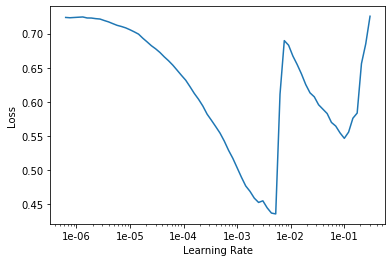

In [31]:
learner.recorder.plot()

In [32]:
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.048037,0.041052,0.978083,22:12
1,0.034995,0.036652,0.981048,20:00


In [33]:
learner.save('head')
learner.load('head')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

Now, we will unfreeze last two last layers and train the model again

In [34]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.033646,0.038024,0.981905,11:47
1,0.033887,0.036767,0.981425,12:17


In [35]:
learner.save('head-2')
learner.load('head-2')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

We will now unfreeze the entire model and train it

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


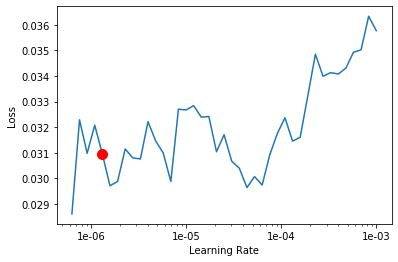

In [36]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [37]:
learner.fit_one_cycle(2, slice(5e-6, 5e-5), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.031875,0.036496,0.981560,21:38
1,0.029987,0.037208,0.982291,18:27


We will now see our model's prediction power

In [38]:
text = 'you are so sweet'
learner.predict(text)

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([2.0871e-04, 2.5996e-05, 7.2458e-05, 1.2313e-05, 2.8451e-05, 3.4274e-05]))

In [39]:
text = 'you are pathetic piece of shit'
learner.predict(text)

(MultiCategory toxic;obscene;insult,
 tensor([1., 0., 1., 0., 1., 0.]),
 tensor([9.9683e-01, 1.6824e-01, 9.8143e-01, 6.4289e-04, 9.7734e-01, 1.1376e-02]))

This is awesome!

With few number of epochs, we are able to get the accuracy of around 98% on this multi-label classification task.

Now, lets see how does Fastai ULMFiT fare on this task

# Fastai - ULMFiT

This will have two parts:

1. Training the Language Model
2. Training the Classifier Model

## Language Model


Important thing to remember in the Language Model is that we train it without label. The basic objective by training language model is to predict the next sentence / words in a sequence of text.

In [40]:
src_lm = ItemLists(path, TextList.from_df(train, path=".", cols = "comment_text"), 
                   TextList.from_df(val, path=".", cols = 'comment_text'))

In [41]:
data_lm = src_lm.label_for_lm().databunch(bs=32)

In [42]:
data_lm.show_batch()

idx,text
0,"there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your"
1,"'s an obsession . xxmaj what 's your point ? xxmaj what are your obsessions doing in article space ? : that is not a good reason to revert one 's edits . xxmaj additionally , the deaths of xxmaj xxunk 's companions are not listed alphabetically , but also not listed by who was born first , which is why i switched the positioning of the two . xxmaj"
2,"faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick"
3,"with your conclusions ( and also that , even though you do n't say anything clearly , i can see what might be your opinion about this xxup ip ) and i will no longer make sockpuppetry accusations in edit summaries . i just hope that xxmaj buspar will listen to your xxunk and will also stop harassing me through edit wars . xxbos xxmaj just wanted to let you"
4,"i suspect to be wrong . xxmaj there exist many devices that are called solid - state an do in fact contain xxunk . \n \n xxmaj another xxmaj question arises about the definition "" "" moving parts "" "" : xxmaj there are devices that contain keys and switches and xxunk , all of them sporting moving ( or movable ) parts and the devices are regarded solid"


In [45]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, model_dir="model")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.20E-02


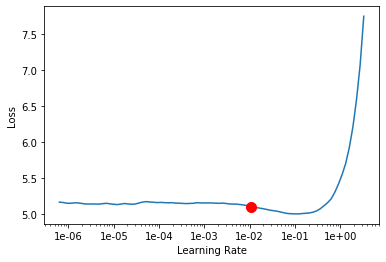

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(1, max_lr=slice(5e-4, 5e-3), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,4.083547,3.923566,0.320891,08:55


In [48]:
learn.save('fit_head')
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (127656 items)
x: LMTextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 4.37E-04


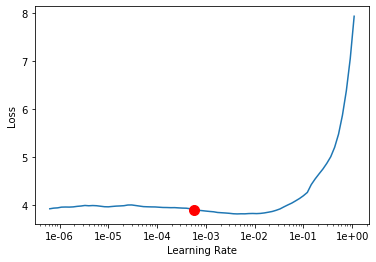

In [49]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(10, max_lr = slice(1e-4, 1e-3), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4,  1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.701277,3.711765,0.346194,10:05
1,3.658217,3.638579,0.359605,09:46
2,3.628577,3.588710,0.368404,09:44
3,3.596001,3.560334,0.373193,10:01
4,3.461856,3.542283,0.375937,09:53
5,3.386634,3.532538,0.377337,09:58
6,3.320113,3.527869,0.378564,09:46
7,3.315945,3.526594,0.378836,09:42
8,3.212142,3.528076,0.378893,09:55
9,3.174291,3.528631,0.378844,10:00


In [51]:
learn.save('fine-tuned')
learn.load('fine-tuned')
learn.save_encoder('fine-tuned')

In [52]:
TEXT = "He is a piece of"
N_WORDS = 10
N_SENTENCES = 2

In [53]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

He is a piece of shit . 
 
  The admins are not being directed
He is a piece of shit . He 's a fucking hero . xxbos


# Classification Model

In [54]:
src_clas = ItemLists(path, TextList.from_df( train, path=".", cols="comment_text", vocab = data_lm.vocab),
                    TextList.from_df( val, path=".", cols="comment_text", vocab = data_lm.vocab))

In [55]:
data_clas = src_clas.label_from_df(cols=label_cols).databunch(bs=32)

In [56]:
data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos "" \n \n \n xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup",toxic
xxbos xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4 = xxmaj j.delanoy xxup is a xxup nigger xxrep 4,toxic
xxbos xxup anyone xxup who xxup supports xxup this xxup is xxup fucking xxup sick . xxup men xxup and xxup underaged xxup fucking xxup kids xxrep 30 ? xxup what xxup in xxup the xxup fuck xxup you xxup all xxup should xxup be xxup shot xxup and xxup killed xxup you xxup bunch xxup of xxup fucking xxup faggot xxup pedophiles \n \n xxwrep 4 xxup die,toxic;severe_toxic;obscene;threat;insult;identity_hate
"xxbos "" \n \n regarding a wiki writer \n \n xxmaj regarding the writer at http : / / rexcurry.net / wikipedialies.html and referenced at http : / / en.wikipedia.org / wiki / xxmaj talk : xxmaj hitler_salute please note the following : xxmaj mr. xxmaj barlow is a nutter with an obsession . xxmaj the history of the salute is now improved in the xxmaj roman salute",


In [57]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, model_dir='model', metrics=acc_02, loss_func=loss_func)
learn.load_encoder('fine-tuned')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 6.31E-02


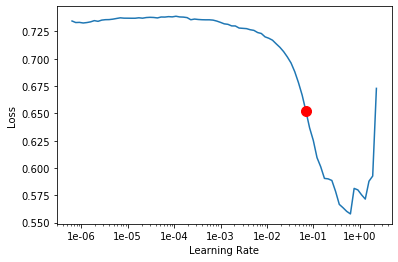

In [58]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [59]:
learn.fit_one_cycle(2, max_lr=slice(1e-3, 1e-2), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.068887,0.063122,0.972207,04:19
1,0.061146,0.062645,0.970328,04:16


In [60]:
learn.save('first-head')
learn.load('first-head')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

In [61]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.064952,1.597279,0.973858,05:04
1,0.064196,1.406804,0.974944,05:25


In [62]:
learn.save('second')
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

In [63]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.081041,6.929391,0.909776,06:33
1,0.059330,0.523655,0.977764,07:05


In [64]:
learn.save('third')
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


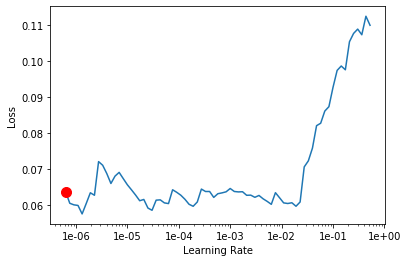

In [65]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [66]:
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.057197,0.185493,0.976296,08:58
1,0.065297,0.405699,0.976943,08:23


In [67]:
learn.predict('she is so sweet')

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([0.0649, 0.0009, 0.0085, 0.0014, 0.0122, 0.0033]))

In [68]:
learn.predict('you are pathetic piece of shit')

(MultiCategory toxic;obscene;insult,
 tensor([1., 0., 1., 0., 1., 0.]),
 tensor([0.9820, 0.3269, 0.9420, 0.0400, 0.8684, 0.1540]))